# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np

training_file = '../data/traffic-signs-data/train.p'
testing_file  = '../data/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test   = test['features'], test['labels']


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [38]:
### Replace each question mark with the appropriate value.

n_train     = X_train.shape[0]
n_test      = X_test.shape[0]

image_shape = (
    X_train.shape[1],
    X_train.shape[2], 
    X_train.shape[3]
)
n_classes   = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples  =", n_test)
print("Image data shape            =", image_shape)
print("Number of classes           =", n_classes)

Number of training examples = 39209
Number of testing examples  = 12630
Image data shape            = (32, 32, 3)
Number of classes           = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

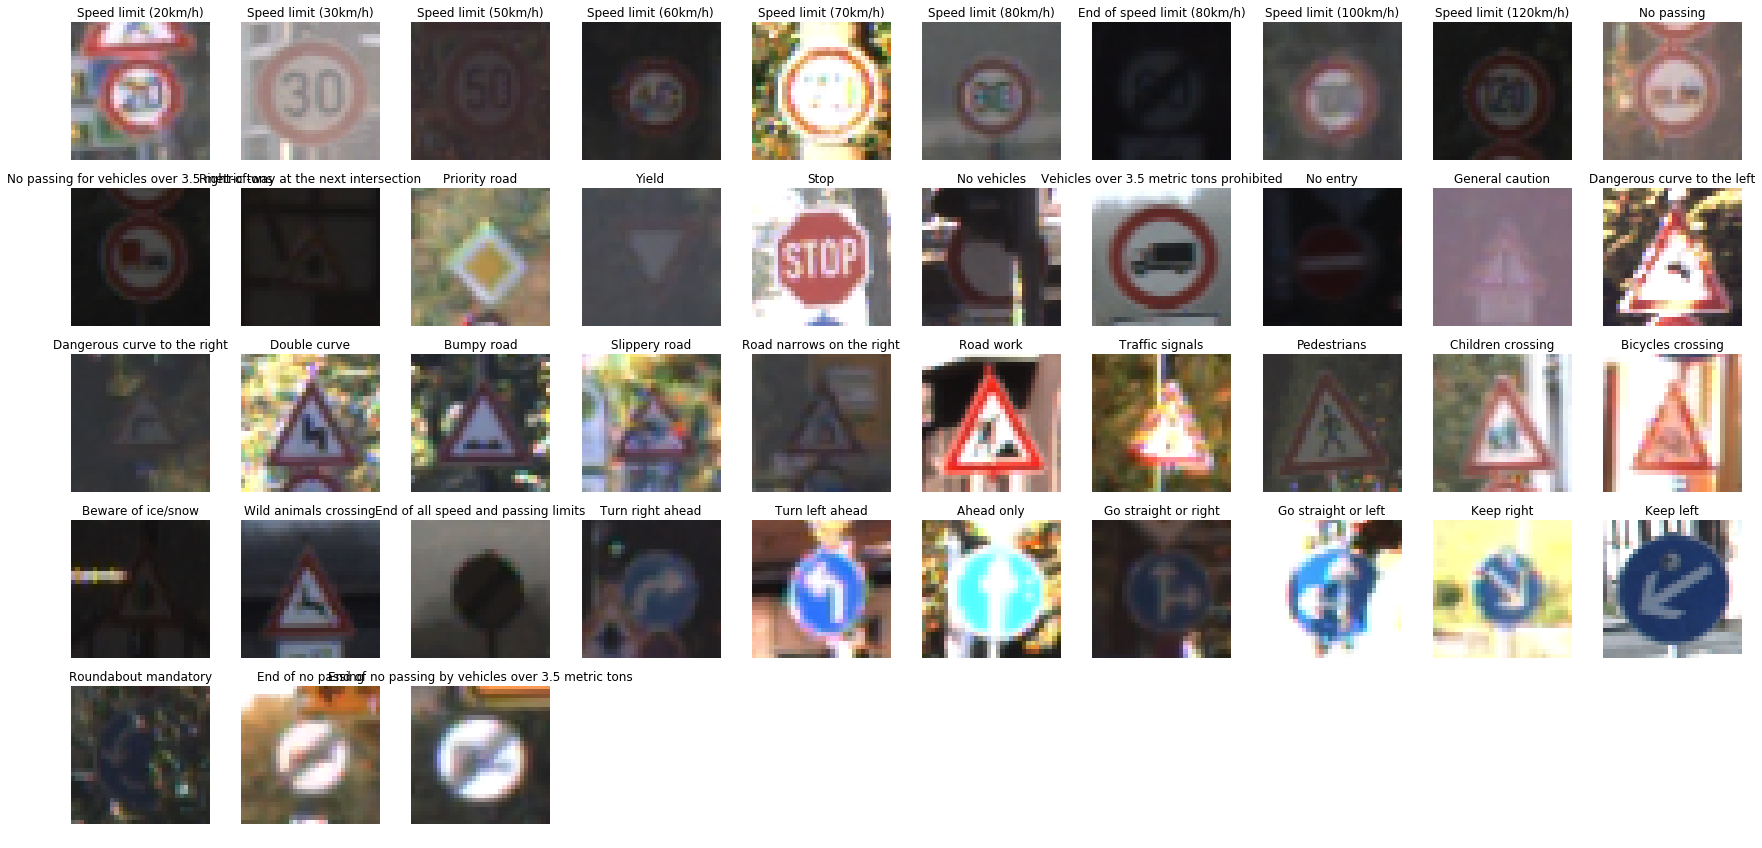

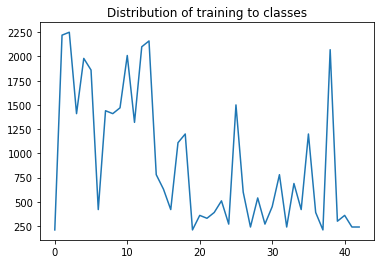

In [18]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import csv

# Visualizations will be shown in the notebook.
%matplotlib inline

fig = plt.figure(figsize=(30, 30))
classes_count = []

labels, uniqueindices = np.unique(y_train, return_index=True)

# Render one image from each of the classes
label_name = []
with open( './signnames.csv', 'rt') as f:
    reader = csv.reader(f)
    label_name = list(reader)
    
    for i, val in enumerate(uniqueindices):
        fig.add_subplot(10, 10, i+1)
        plt.axis('off')
        plt.title(label_name[y_train[val]+1][1])
        plt.imshow(X_train[val])
f.close()
plt.show()


# Print the distribution of the training data
for i in labels:
    classes_count.append(np.sum(y_train == i)) 

plt.figure()

plt.plot(classes_count)
plt.title('Distribution of training to classes')


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation notes

I would propose the following folow: 

- Perform data augmentation (rotating, blurring, shifting, shearing, changing brightness). To do this I created a ImagePreprocessor class.
- Build CNN withour size image is : 32x32x3.
- Train the CNN. For this I created TrafficSignCalassifierNet class with train public method as this should be cleaner implementation and better than inline coding style.
- Test on new images. Again we will be using TrafficSignCalassifierNet and predict public method to classify the image.




Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.


**Explaining ImagePreprocessor**

- Calculate how many images in one traffic sign
- For each data set, I generate new images randomly based on current total images
- Calculate the average and based on that average, we can estimate how many images needed for each traffic sign
- First, separate each traffic sign training set into different arrays
- Second, for each data set, I generate new images randomly based on current total images
- ImagePreprocessor uses ImageEffect class to generate random effects like rotate, blur, shear, gomma and translate shape.



In [1]:
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os.path


# Provide some random effects. 
class ImageEffect:

    def random_effect(self, img):
        a = np.random.randint(0, 2, [1, 5]).astype('bool')[0]

        if a[0] == True:
            img = self.image_translate(img)
        if a[1] == True:
            img = self.image_rotate(img)
        if a[2] == True:
            img = self.image_shear(img)
        if a[3] == True:
            img = self.image_blur(img)
        if a[4] == True:
            img = self.image_gamma(img)
        return img


    def image_translate(self, img):
        x = img.shape[0]
        y = img.shape[1]

        x_shift = np.random.uniform(-0.3 * x, 0.3 * x)
        y_shift = np.random.uniform(-0.3 * y, 0.3 * y)

        shift_matrix = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
        shift_img = cv2.warpAffine(img, shift_matrix, (x, y))

        return shift_img


    def image_rotate(self, img):
        row, col, channel = img.shape

        angle = np.random.uniform(-60, 60)
        rotation_point = (row / 2, col / 2)
        rotation_matrix = cv2.getRotationMatrix2D(rotation_point, angle, 1)

        rotated_img = cv2.warpAffine(img, rotation_matrix, (col, row))
        return rotated_img


    def image_shear(self, img):
        x, y, channel = img.shape

        shear = np.random.randint(5,15)
        pts1 = np.array([[5, 5], [20, 5], [5, 20]]).astype('float32')
        pt1 = 5 + shear * np.random.uniform() - shear / 2
        pt2 = 20 + shear * np.random.uniform() - shear / 2
        pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])

        M = cv2.getAffineTransform(pts1, pts2)
        result = cv2.warpAffine(img, M, (y, x))
        return result


    def image_blur(self, img):
        r_int = np.random.randint(0, 2)
        odd_size = 2 * r_int + 1
        return cv2.GaussianBlur(img, (odd_size, odd_size), 0)


    def image_gamma(self, img):
        gamma = np.random.uniform(0.3, 1.5)
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        new_img = cv2.LUT(img, table)
        return new_img


class ImagePreprocessor():

    OUTPUT_FILE   = '../data/traffic-signs-data/train_preprocessed.p'
    SCALE_FACTOR  = 3.5
    TRAINING_FILE = '../data/traffic-signs-data/train.p'

    def __init__(self):
        plt.interactive(False)

        self.train_data = self.load_data()
        self.image_effect = ImageEffect()

        self.X_train = self.train_data['features']
        self.y_train = self.train_data['labels']

    def call(self):

        self.extended_data, self.extended_labels = self.augment_data(
            self.X_train,
            self.y_train,
            scale=self.SCALE_FACTOR
        )

        self.new_train_data = {
            'features': self.extended_data,
            'labels': self.extended_labels
        }

        self.save_data()

    def plot_samples(self):
        item, count = np.unique(self.y_train, return_counts=True)
        freq = np.array((item, count)).T

        item2, count2 = np.unique(self.extended_labels, return_counts=True)
        freq2 = np.array((item2, count2)).T


        print('Before Data Preprocessing: %d samples' % (self.y_train.shape[0]))

        plt.figure(1)
        plt.bar(item, count, alpha=0.2)
        plt.title('Before Data Preprocessing: Unequally Distributed Data')

        print('After Data Preprocessing: %d samples' % (self.extended_labels.shape[0]))

        plt.figure(2)
        plt.bar(item2, count2, alpha=0.2)
        plt.title('After Data Preprocessing: More Equally Distributed Data')

        plt.show()


    def augment_data(self, X_train, y_train, scale=2):
        total_traffic_signs = len(set(y_train))

        ts, imgs_per_sign   = np.unique(y_train, return_counts=True)

        avg_per_sign        = np.ceil(np.mean(imgs_per_sign)).astype('uint32')

        separated_data      = []

        for traffic_sign in range(total_traffic_signs):
            images_in_this_sign = X_train[y_train == traffic_sign, ...]
            separated_data.append(images_in_this_sign)

        expanded_data   = np.array(np.zeros((1, 32, 32, 3)))
        expanded_labels = np.array([0])

        for sign, sign_images in enumerate(separated_data):
            scale_factor = (scale*(avg_per_sign / imgs_per_sign[sign])).astype('uint32')
            print(sign, " ", avg_per_sign / imgs_per_sign[sign], " ", scale_factor)

            new_images = []

            for img in sign_images:
                for _ in range(scale_factor):
                    new_images.append(self.image_effect.random_effect(img))

            if len(new_images) > 0:
                sign_images = np.concatenate((sign_images, new_images), axis=0)

            new_labels      = np.full(len(sign_images), sign, dtype='uint8')

            expanded_data   = np.concatenate((expanded_data, sign_images), axis=0)
            expanded_labels = np.concatenate((expanded_labels, new_labels), axis=0)

        return expanded_data[1:], expanded_labels[1:]


    def save_data(self, output_path=OUTPUT_FILE):
        bytes_out = pickle.dumps(self.new_train_data)
        max_bytes = 2**31 - 1
        n_bytes   = sys.getsizeof(bytes_out)

        with open(output_path, 'wb') as f:
            for idx in range(0, n_bytes, max_bytes):
                f.write(bytes_out[idx:idx+max_bytes])

        return True

    def load_data(self, train_path=TRAINING_FILE):
        bytes_in = bytearray(0)
        input_size = os.path.getsize(train_path)
        max_bytes = 2**31 - 1

        with open(train_path, mode='rb') as f:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f.read(max_bytes)
        train = pickle.loads(bytes_in)

        return train

# Perform Image Preprocessing 
from image_preprocessor import ImagePreprocessor

image_preprocessor = ImagePreprocessor()
image_preprocessor.call()

# Output format:
"sign_class_type - (avg_per_sign / imgs_per_sign) - scale_factor"



0   4.34285714286   15
1   0.410810810811   1
2   0.405333333333   1
3   0.646808510638   2
4   0.460606060606   1
5   0.490322580645   1
6   2.17142857143   7
7   0.633333333333   2
8   0.646808510638   2
9   0.620408163265   2
10   0.453731343284   1
11   0.690909090909   2
12   0.434285714286   1
13   0.422222222222   1
14   1.16923076923   4
15   1.44761904762   5
16   2.17142857143   7
17   0.821621621622   2
18   0.76   2
19   4.34285714286   15
20   2.53333333333   8
21   2.76363636364   9
22   2.33846153846   8
23   1.78823529412   6
24   3.37777777778   11
25   0.608   2
26   1.52   5
27   3.8   13
28   1.68888888889   5
29   3.37777777778   11
30   2.02666666667   7
31   1.16923076923   4
32   3.8   13
33   1.3236574746   4
34   2.17142857143   7
35   0.76   2
36   2.33846153846   8
37   4.34285714286   15
38   0.440579710145   1
39   3.04   10
40   2.53333333333   8
41   3.8   13
42   3.8   13


'sign_class_type - (avg_per_sign / imgs_per_sign) - scale_factor'

In [4]:
new_training_data = image_preprocessor.new_train_data
new_features = new_training_data['features']
new_features = new_features/255 # scale pixel values to [0, 1]
new_labels   = new_training_data['labels']

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

- Perform data transformations with shear, rotate, changing brightness on original image.
- Normalize images from (0->255) to (0->1) since I don't want high variance in the data. It would be harder for the classifier to tune the learning rate.

All methods related to process data is stored in image_processor.py. 

Preprocessing the images was important to set the data distribution, each traffic sign has different amount of data. If the '20KM' traffic sign has more data than '70KM' sign, the network will be more biased toward the '20KM' sign. 

Data distrubution of German Traffic Sign Data Set(before)

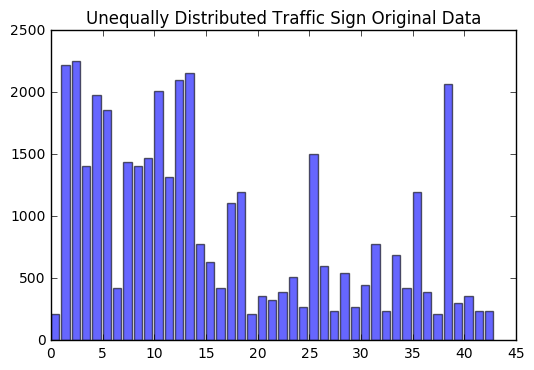

In [5]:
# Create a barchart of frequencies for original data 
item, count = np.unique(y_train, return_counts=True)
freq = np.array((item, count)).T
plt.figure(1)
plt.bar(item, count, alpha=0.6)
plt.title('Unequally Distributed Traffic Sign Original Data')

plt.show()


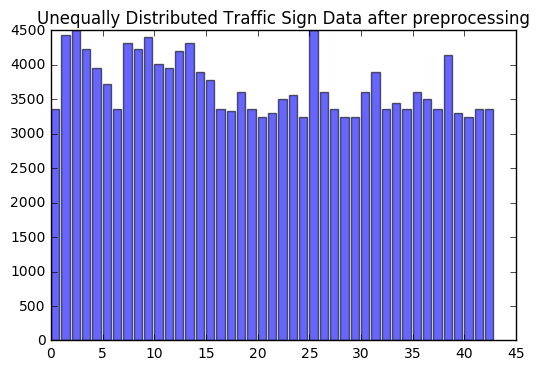

In [6]:
# Create a barchart of frequencies for modified data 
item, count = np.unique(new_labels, return_counts=True)
freq = np.array((item, count)).T
plt.figure(2)
plt.bar(item, count, alpha=0.6)
plt.title('Unequally Distributed Traffic Sign Data after preprocessing')
plt.show()

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I used the testing data as it is and divided training data into training and validation data. 
I generated additional data by randomly rotating, translating and shearing the training images. 

### How did I perform data transformation?

- Define ImageEffect class and e few image transformation methods (rotation, shift, shear, blurr , change gamma).
- Define a method random_effect() to randomly apply multiple transformation on one image.
- Define ImagePreprocessor class and augment_data() method to perform data augmentation on original data set.

Since the traffic sign samples is not distrubted equally, this could affect the CNN's performance. The network would be biased toward classes with more samples. Data Augmentation generates additional data on each traffic sign.
For example, if the average sample for each classes is 1000 images. Any class has less than 300 images need to generate more data.
Data Augmentation includes but not limited to blurring, rotating, shearing, translating, changing brighness on original images. 


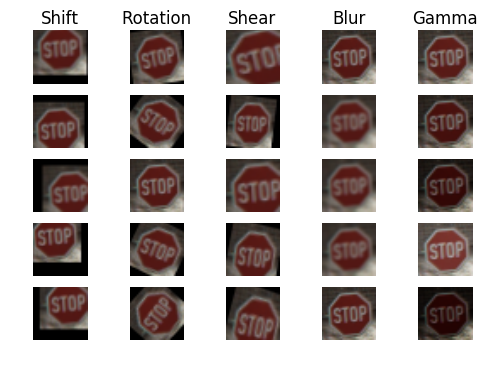

In [7]:
from image_effect import ImageEffect
image_effect = ImageEffect()

# Sample to generate 5 images per transformation on a random image of training set.

sample = X_train[22750]

translated_img = []
rotated_img    = []
shear_img      = []
blur_img       = []
noise_img      = []
gamma_img      = []

for i in range(5):
    translated_img.append(image_effect.image_translate(sample))
    rotated_img.append(image_effect.image_rotate(sample))
    shear_img.append(image_effect.image_shear(sample))
    blur_img.append(image_effect.image_blur(sample))
    gamma_img.append(image_effect.image_gamma(sample))
    
row, col = 5, 5
plt.figure(2)

plt.subplot(row, col,1), plt.title('Shift'), 
plt.subplot(row, col,2), plt.title('Rotation')
plt.subplot(row, col,3), plt.title('Shear'), 
plt.subplot(row, col,4), plt.title('Blur')
plt.subplot(row, col,5), plt.title('Gamma')

for i in range(5):
    pos = 5*i
    plt.subplot(row, col,pos+1), plt.imshow(translated_img[i]),  plt.axis('off')
    plt.subplot(row, col,pos+2), plt.imshow(rotated_img[i]), plt.axis('off') 
    plt.subplot(row, col,pos+3), plt.imshow(shear_img[i]), plt.axis('off')
    plt.subplot(row, col,pos+4), plt.imshow(blur_img[i]), plt.axis('off')  
    plt.subplot(row, col,pos+5), plt.imshow(gamma_img[i]), plt.axis('off')

plt.show()

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

Proposed architecture:

  - Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x32. pad='SAME'
  - Layer 2: Convolutional. Output = 28x28x32. pad='SAME'. (Two 3x3x16 filters)
  - Pooling. Input = 28x28x32. Output = 14x14x32.
  - Dropout (0.6)
  - Layer 3: Convolutional. (3x3x64)
  - Layer 4: Convolutional. (3x3x64)
  - Pooling. (2x2)
  - Dropout (0.6)
  - Layer_5: Convolutional. (3x3x128)
  - Flatten (1152)
  - Layer 6: Fully connected (1024)
  - Dropout (0.6)
  - Layer 7: Fully connected (512)
  - Layer 8: Fully connected (43)
  
Notes : 

 I compared both, the original data set and training data after augmentations, and validated the testing data test for both:
 
 - I starte with training the original training data 
   - Saved the resuts to `model-convnet-tsc.chkpt`
   - Started with 50 epochs but nothing changed after 25 epocs
   - Validation with testing data results: 0.969 accuracy

 - Trained the extended training data with transormation
   - I started with splitting my data using train_test_split then moved to use StratifiedShuffleSplit
   - 
   - The training was slow. Maybe I needed to consider to:
     - Add less data 
     - Remove some effects like transorm and rotate
     - Try more epochs: maybe 100 ? 
   - Saved the resuts to `model-convnet-tsc-extended.chkpt`
   - Validation with testing data results: 0.992 accuracy
   - I used AdamOptimizer for the optimizer

 - I found way better results once I normalize images features (X_features/255) (255->1)
 


In [2]:
import time
import numpy as np

import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit


import cv2
import numpy as np


# The main class for traffic sign classifier
class TrafficSignClassifierNet(object):

    def __init__(self):

        self.learn_rate    = 0.001
        self.batch_size    = 128
        self.keep_prob     = 0.65
        self.features      = tf.placeholder(tf.float32, (None, 32, 32, 3))
        self.labels        = tf.placeholder(tf.int32, None)
        self.kp            = tf.placeholder(tf.float32)
        self.learning_rate = tf.placeholder(tf.float32)
        self.mu            = 0
        self.sigma         = 0.1
        self.acc_threshold = 0.991
        self.epochs        = 100
        self.sess          = tf.Session()
        self.logs_path     = '../data/logs'
        
        self.sess.run(tf.global_variables_initializer())
        self.build_convnet()
        

    def build_convnet(self):

        # Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x32.
        conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 32), mean = self.mu, stddev = self.sigma))
        conv1_b = tf.Variable(tf.zeros(32))
        conv1   = tf.nn.conv2d(self.features, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
        conv1   = tf.nn.relu(conv1)

        # Layer 2: Convolutional. Output = 28x28x32.
        conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = self.mu, stddev = self.sigma))
        conv2_b = tf.Variable(tf.zeros(32))
        conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
        conv2   = tf.nn.relu(conv2)

        # Pooling. Input = 28x28x32. Output = 14x14x32.
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        conv2 = tf.nn.dropout(conv2, keep_prob = self.kp)

        # Layer 3: Convolutional. Iutput = 14x14x32. Output = 12x12x64
        conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = self.mu, stddev = self.sigma))
        conv3_b = tf.Variable(tf.zeros(64))
        conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
        conv3   = tf.nn.relu(conv3)

        # Layer 4: Convolutional. Iutput = 12x12x64. Output = 10x10x64
        conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = self.mu, stddev = self.sigma))
        conv4_b = tf.Variable(tf.zeros(64))
        conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='VALID') + conv4_b
        conv4   = tf.nn.relu(conv4)

        # Pooling. Input = 10x10x64. Output = 5x5x64.
        conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        conv4 = tf.nn.dropout(conv4, keep_prob = self.kp)

        # Layer 5: Convolutional. Iutput = 5x5x64. Output = 3x3x128
        conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = self.mu, stddev = self.sigma))
        conv5_b = tf.Variable(tf.zeros(128))
        conv5   = tf.nn.conv2d(conv4, conv5_W, strides=[1, 1, 1, 1], padding='VALID') + conv5_b
        conv5   = tf.nn.relu(conv5)

        # Flatten. Input = 3x3x128. Output = 1152.
        fc0   = flatten(conv5)

        # Layer 3: Fully Connected. Input = 2048. Output = 1024.
        fc1_W = tf.Variable(tf.truncated_normal(shape=(1152, 1024), mean = self.mu, stddev = self.sigma))
        fc1_b = tf.Variable(tf.zeros(1024))
        fc1   = tf.matmul(fc0, fc1_W) + fc1_b

        # Activation.
        fc1 = tf.nn.relu(fc1)
        fc1 = tf.nn.dropout(fc1, keep_prob = self.kp)

        # Layer 4: Fully Connected. Input = 1024. Output = 1024.
        fc2_W  = tf.Variable(tf.truncated_normal(shape=(1024, 1024), mean = self.mu, stddev = self.sigma))
        fc2_b  = tf.Variable(tf.zeros(1024))
        fc2    = tf.matmul(fc1, fc2_W) + fc2_b

        # Activation.
        fc2 = tf.nn.relu(fc2)
        fc2 = tf.nn.dropout(fc2, keep_prob = self.kp)

        # Layer 5: Fully Connected. Input = 1024. Output = 43.
        fc3_W       = tf.Variable(tf.truncated_normal(shape=(1024, 43), mean = self.mu, stddev = self.sigma))
        fc3_b       = tf.Variable(tf.zeros(43))
        self.logits = tf.matmul(fc2, fc3_W) + fc3_b

    def accuracy_score(self, X_test, y_test, file_path):
        
        loader = tf.train.import_meta_graph(file_path)
        loader.restore(self.sess, tf.train.latest_checkpoint('./'))
        print("Restored Model Successfully.")
        
        one_hot_y     = tf.one_hot(self.labels, len(set(y_test)))
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(self.logits, one_hot_y)
        loss          = tf.reduce_mean(cross_entropy)
        optimizer     = tf.train.AdamOptimizer(self.learning_rate).minimize(loss)

        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(one_hot_y, 1))
        accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        test_accuracy = []
        test_iter = int(len(X_test)/self.batch_size)

        for i in range(test_iter):
            X_test_batch = X_test[i*self.batch_size:(i+1)*self.batch_size]
            y_test_batch = y_test[i*self.batch_size:(i+1)*self.batch_size]
            test_accuracy = self.sess.run(accuracy_operation, feed_dict={
                self.features: X_test_batch,
                self.labels: y_test_batch,
                self.kp: 1.0,
                self.learning_rate: self.learn_rate})

        print("testing accuracy: {:0.3f}".format(test_accuracy))
    
    def predict(self, img, saved_model='model-convnet-tsc.chkpt.meta'):
        try:
            loader = tf.train.import_meta_graph(saved_model)
            loader.restore(self.sess, tf.train.latest_checkpoint('./'))
            print("Restored Model Successfully.")
        except Exception as e:
            print("No model found...Start building a new one")
        
        result = None

        if len(img) > 5000:
            for offset in range(0, len(img), self.batch_size):
                end = offset + self.batch_size
                batch_x = img[offset:end]
                predictions = session.run(model, feed_dict={self.features: batch_x})
                if result is None:
                    result = predictions
                else:
                    result = np.concatenate((result, predictions))
        else:
            predictions = self.sess.run(model, feed_dict={self.features: img})
            if result is None:
                result = predictions
            else:
                result = np.concatenate((result, predictions))

        return result

    def train(self, x_train, y_train, file_path='model-convnet-tsc.chkpt'):

#         X_train, X_val, y_train, y_val = train_test_split(
#             x_train, y_train, train_size=0.8, test_size=0.20, random_state=42
#         )
        
        sss = StratifiedShuffleSplit(y_train, n_folds=2, test_size=0.2, random_state=42)
        
        for train_index, test_index in sss:
            X_train, X_val = x_train[train_index], x_train[test_index]
            y_train, y_val = y_train[train_index], y_train[test_index]

        one_hot_y = tf.one_hot(self.labels, len(set(y_train)))

        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(self.logits, one_hot_y)

        loss = tf.reduce_mean(cross_entropy)

        optimizer = tf.train.AdamOptimizer(self.learn_rate).minimize(loss)

        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(one_hot_y, 1))
        accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        saver = tf.train.Saver() 

        start_time = time.clock()

        print("Start training...")

        try:
            loader = tf.train.import_meta_graph((file_path+'.meta'))
            loader.restore(self.sess, tf.train.latest_checkpoint('./'))
            print("Restored Model Successfully.")
        except Exception as e:
            print("No model found...Start building a new one")
        
        writer = tf.train.SummaryWriter(self.logs_path, graph=tf.get_default_graph())

        for x in range(self.epochs):
            num_iter = int(len(X_train)/self.batch_size)
            for i in range(num_iter):
                X_batch = X_train[i*self.batch_size:(i+1)*self.batch_size]
                y_batch = y_train[i*self.batch_size:(i+1)*self.batch_size]

                self.sess.run(optimizer, feed_dict={
                    self.features: X_batch,
                    self.labels: y_batch,
                    self.kp: self.keep_prob,
                    self.learning_rate: self.learn_rate})

            val_accuracy    = []
            validation_iter = int(len(X_val)/self.batch_size)
            for i in range(validation_iter):
                X_val_batch = X_val[i*self.batch_size:(i+1)*self.batch_size]
                y_val_batch = y_val[i*self.batch_size:(i+1)*self.batch_size]
                val_accuracy.append(
                    self.sess.run(accuracy_operation, feed_dict={
                        self.features:X_val_batch,
                        self.labels: y_val_batch,
                        self.kp: 1}))

            print("Epoch: {}    Validation accuracy:{:.3f}".format(x, np.mean(np.array(val_accuracy))))


        saver.save(self.sess, file_path)
        print("Train Model saved")

        # Calculate runtime and print out results
        train_time = time.clock() - start_time
        m, s = divmod(train_time, 60)
        h, m = divmod(m, 60)
        print("Optimization Finished!! Training time: %02dh:%02dm:%02ds"% (h, m, s))


conv_net = TrafficSignClassifierNet()
X_train = X_train/255 # Normalize the data 
conv_net.train(X_train, y_train, "model-convnet-tsc.chkpt")



/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Start training...
Restored Model Successfully.
Epoch: 0    Validation accuracy:0.993
Epoch: 1    Validation accuracy:0.994
Epoch: 2    Validation accuracy:0.994
Epoch: 3    Validation accuracy:0.994
Epoch: 4    Validation accuracy:0.995
Epoch: 5    Validation accuracy:0.994
Epoch: 6    Validation accuracy:0.994
Epoch: 7    Validation accuracy:0.996
Epoch: 8    Validation accuracy:0.993
Epoch: 9    Validation accuracy:0.995
Epoch: 10    Validation accuracy:0.994
Epoch: 11    Validation accuracy:0.995
Epoch: 12    Validation accuracy:0.995
Epoch: 13    Validation accuracy:0.995
Epoch: 14    Validation accuracy:0.995
Epoch: 15    Validation accuracy:0.996
Epoch: 16    Validation accuracy:0.995
Epoch: 17    Validation accuracy:0.995
Epoch: 18    Validation accuracy:0.996
Epoch: 19    Validation accuracy:0.995
Epoch: 20    Validation accuracy:0.997
Epoch: 21    Validation accuracy:0.995
Epoch: 22    Validation accuracy:0.997
Epoch: 23    Validation accuracy:0.996
Epoch: 24    Validation acc

In [3]:
conv_net.accuracy_score((X_test/255), y_test, "model-convnet-tsc.chkpt.meta")

testing accuracy: 0.969


In [4]:
conv_net.accuracy_score(X_test, y_test, "model-convnet-tsc.chkpt.meta")

testing accuracy: 0.938


In [3]:

training_file = '../data/traffic-signs-data/train_preprocessed.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']

# Model name : "model-convnet-tsc-extended.chkpt"

conv_net_extended = TrafficSignClassifierNet()
X_train = X_train/255
conv_net_extended.train(X_train, y_train)


Start training...
No model found...Start building a new one
Epoch: 0    Validation accuracy:0.552
Epoch: 1    Validation accuracy:0.744
Epoch: 2    Validation accuracy:0.816
Epoch: 3    Validation accuracy:0.853
Epoch: 4    Validation accuracy:0.873
Epoch: 5    Validation accuracy:0.894
Epoch: 6    Validation accuracy:0.902
Epoch: 7    Validation accuracy:0.909
Epoch: 8    Validation accuracy:0.915
Epoch: 9    Validation accuracy:0.916
Epoch: 10    Validation accuracy:0.922
Epoch: 11    Validation accuracy:0.911
Epoch: 12    Validation accuracy:0.919
Epoch: 13    Validation accuracy:0.928
Epoch: 14    Validation accuracy:0.929
Epoch: 15    Validation accuracy:0.935
Epoch: 16    Validation accuracy:0.930
Epoch: 17    Validation accuracy:0.931
Epoch: 18    Validation accuracy:0.935
Epoch: 19    Validation accuracy:0.935
Epoch: 20    Validation accuracy:0.934
Epoch: 21    Validation accuracy:0.933
Epoch: 22    Validation accuracy:0.936
Epoch: 23    Validation accuracy:0.940
Epoch: 24    V

In [5]:
training_file = '../data/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    test = pickle.load(f)
    
X_test, y_test = test['features'], test['labels']

conv_net_extended.accuracy_score(X_test/255, y_test, "model-convnet-tsc-extended.chkpt.meta")

testing accuracy: 0.992


In [10]:
# X_test = X_test/255

one_hot_y     = tf.one_hot(conv.labels, len(set(y_test)))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(conv.logits, one_hot_y)
loss          = tf.reduce_mean(cross_entropy)
optimizer     = tf.train.AdamOptimizer(conv.learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(conv.logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

test_accuracy = []
test_iter = int(len(X_test)/conv.batch_size)

for i in range(test_iter):
    X_test_batch = X_test[i*conv.batch_size:(i+1)*conv.batch_size]
    y_test_batch = y_test[i*conv.batch_size:(i+1)*conv.batch_size]
    test_accuracy = conv.sess.run(accuracy_operation, feed_dict={
        conv.features: X_test_batch,
        conv.labels: y_test_batch,
        conv.kp: 1.0,
        conv.learning_rate: conv.learn_rate})

print("testing accuracy: {:0.3f}".format(test_accuracy))
        
# conv.train((X_train/255), y_train, "model-convnet-tsc.chkpt")

# conv.accuracy_score(X_test/255, y_test, "model-convnet-tsc.chkpt.meta")

# loader = tf.train.import_meta_graph(('model-convnet-tsc.chkpt.meta'))
# loader.restore(conv.sess, tf.train.latest_checkpoint('./'))
# print("Restored Model Successfully.")

# conv_net = TrafficSignClassifierNet()
# conv_net.accuracy_score(X_test/255, y_test, "model-convnet-tsc-extended.chkpt.meta")


testing accuracy: 0.984


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

* Hyperparameters:
    - Dropout keep_prob: 0.6
    - Batches: batch_size : 128
    - Epochs : 50
    - Hyperparameters : mu = 0, sigma = 0.1 for weight initialization, 
    - learning rate = 0.0001

* Optimizer:
    - Adam Optimzer
    

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

It was mainly a trial and error and using logic. I tried different ConvNets implementations like (VGG-16) then moved to the final implementation here. The training was an expensive and slow process so I had to run my tests using EC2 instance with GPU and run my tests there. 

I tried LeNet with dropout attached to the fully connected layers, but it did not show satisfactory performance, therefore I tried different implementations and ended up with this one.

Then I started to train the network, but the performance was not good at the begining, then after I tuned the hyper parameters, the network started to show some improvement. 

After a lot of trial and error I was able to achieve a testing accuracy of about *0.992* percent

- Datasets (orignal and extended:
  - Started by training the provided data set and validate my results using the testing dataset.
  - Trained the training dataset after adding the data augmentation (extended_data)
  - Saved the models for both training sets.
  - Compared results between the two networks and decided to go with the extended model
 
I found that setting the learning rate decay is very important. Drop-out magically boosted the accuracy too. I attemped to try L1, L2 regularization but the result is not as good as drop-out. 

I Normalized the data `features/255` and I got better results

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

**Steps**

- Read `signnames.csv` file and create dictionary {label: 'name'}
- Load the custom test images, resizing them to 32x32x3 and saving them in ReshapedImages
- Plot the images


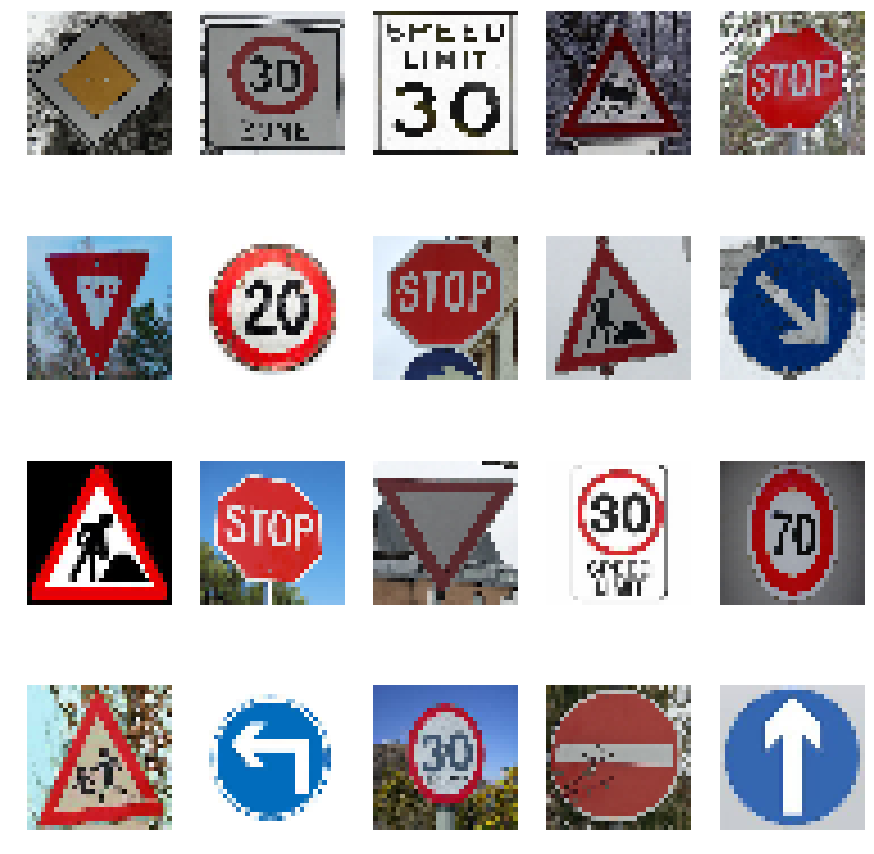

In [12]:
import csv
import os
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

signnames = {}

with open('signnames.csv', 'rt') as csvfile:
    signreader = csv.reader(csvfile)
    for x in signreader:
        signnames[x[0]] = x[1]

test_images = []
path = './test_images/'

plt.figure(figsize=(15, 20))

for image in os.listdir(path):
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_images.append(img)
              
test_images = np.array(test_images)
test_images = test_images/255

for i, image in enumerate(test_images):
    grid = plt.subplot(len(test_images)/4,5,i+1)
    grid.imshow(image), plt.axis('off')
    
plt.show()



### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._


**Answer:**

If the image has significant difference from the training data, such as pose, position, lighting condition, color, etc, it will be very hard for the network to classify it correctly. However luckly with the augmented data i added the model can detect images in a good accuracy. 

Image 1: Road work. This one is very clear and similar to what we have in training data, so it should not be difficult to classify.

Image 2,3: Stop sign. This sign contains background and it is slightly tilt. So I would like to double check if the model has pose invariance.

Image 4,5,6: Speed limit 30. All of the three images are not standard one, image 4 has some background and letters below the "30", and as well as the image 5. The image 6 is totally different one, which is what I can see in my daily life but not in the training dataset. So there are some noise more or less, it is a great point to verify the performance.

Image 7: Speed limit 20.

Image 8: Speed limit 70. Image 7 and 8 also have some similar features, which is "20" and "70" may be difficlut to distinguish from each other.

Image 9: Turn left ahead. The classifier may be confused by this one, comparing to "Double curve" which looks a little bit similar in 32 x 32 scale/

Image 10: Ahead only. This one is another standard one and should be a easy one.

The accuracy shouldn't get effected much with brightness, contrast .etc as such effects have been added to the modified training set

Two of the signs do not have any equivalent counterparts in the training set. Two other signs do have equivalent counterparts, but they are slightly different in shape. Only one of the sign has similarly shaped equivalent counterpart in the Germany dataset


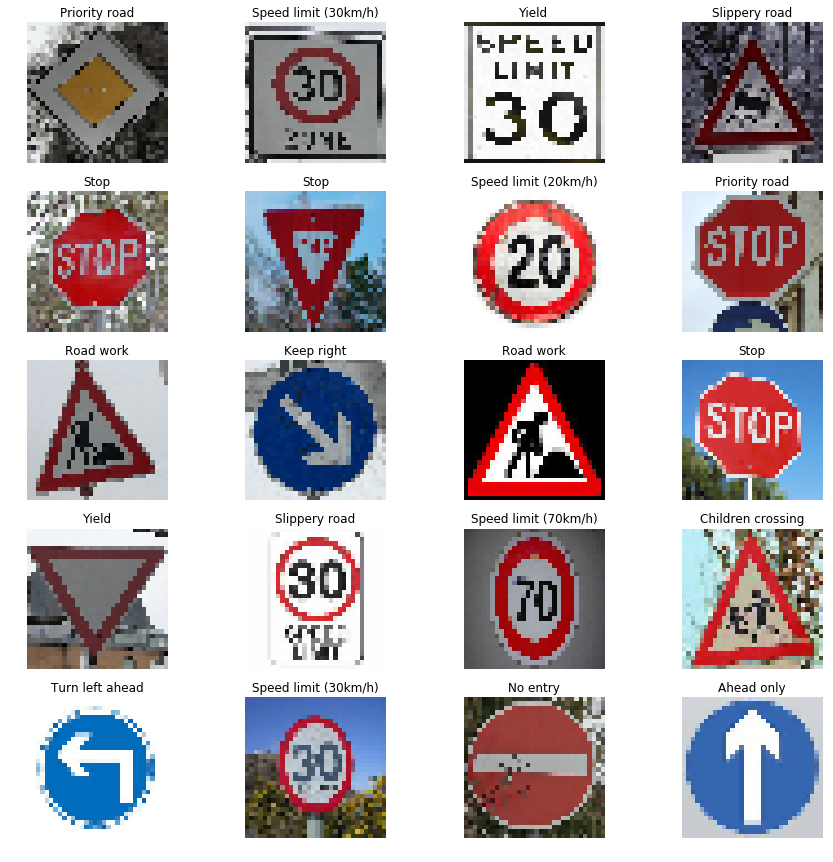

In [21]:

loader = tf.train.import_meta_graph('model-convnet-tsc-extended.chkpt.meta')
loader.restore(conv_net_extended.sess, tf.train.latest_checkpoint('./'))
output = conv_net_extended.sess.run(conv_net_extended.logits, feed_dict={
        conv_net_extended.features: test_images, conv_net_extended.kp: 1})
outputclass = np.argmax(output, axis = 1)

plt.figure(figsize=(10,4))

for i, image in enumerate(test_images):
    grid = plt.subplot(len(test_images)/4,5,i+1)
    grid.imshow(image), plt.axis('off')
    plt.title(signnames[str(outputclass[i])])

plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The model performed fairly well on test images (~ 99.2%). 
However, if the sign is one of the difficult images like above, the accuracy will drop (~85%).
I think it is important to augment more data on these specific datasets to make my model more accurate.

The trained model is able to provide reasonable prediction of new images.

I can use the "30mph" classification as an expamle. I tried 3 diffrent "30 mph" speed limit sign. The first one is the nomal one, and the neural network is able to classify it successfully. For the second one, the "30" is not in the middle of the image, and there is a "speed limit" label below it. And the third one is totally different one from what we trained before. So the network cannot classfiy them correctly.

It means the netural network still have some limitations. First of all, your training data should contains different types, lighting condtions and scenarios.

I also tried some other dataset, and I found the classifier always have the similar confusions. For example, mess up "20" and "70", "30" and "80". And for some traffic sign with little training data, e.g. ['29', 'Bicycles crossing'] with only 270 example, it will have a very hign chance to get wrong prediction.
So in order to get better performance, I should train a more complex convlutional neural network, and use more and more data to train it, and tuning the training parameters as well.

I'm satisfied with most of the predictions. 
The accuracy on Question 5 is 100% and around 85% for difficult images.

In [ ]:

# output = conv.sess.run(
#             conv.logits, feed_dict={
#                 conv.features: test_images, 
#                 conv.kp: 1}
# )

# outputclass = np.argmax(output, axis = 1)

# plt.figure(figsize=(15,15))

# for i, image in enumerate(test_images):
#     grid = plt.subplot(len(test_images)/4,4,i+1)
#     grid.imshow(image), plt.axis('off')
#     plt.title(signnames[str(outputclass[i])])

# plt.show()


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

I got Some good results. I can get better results if I have more time to train on missed prediction by using more data. Fortunately, correct label always appear in top_k prediction.

In [38]:
loader = tf.train.import_meta_graph('model-convnet-tsc-extended.chkpt.meta')
loader.restore(conv_net_extended.sess, tf.train.latest_checkpoint('./'))

top_K_values, top_K_indices = conv_net_extended.sess.run(tf.nn.top_k(output, k=3 ))
top_K_labels = []

for x in top_K_indices:
    dummy = []
    for y in x:
        dummy.append(signnames[str(y)])
    top_K_labels.append(dummy)
    print(dummy)



['Priority road', 'No entry', 'Bicycles crossing']
['Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (20km/h)']
['Slippery road', 'Children crossing', 'Dangerous curve to the left']
['Stop', 'Yield', 'No entry']
['Stop', 'No entry', 'Bicycles crossing']
['Road work', 'Dangerous curve to the right', 'Children crossing']
['Keep right', 'Keep left', 'Go straight or left']
['Yield', 'Bicycles crossing', 'No vehicles']
['Children crossing', 'Bicycles crossing', 'Beware of ice/snow']
['No entry', 'Stop', 'No passing for vehicles over 3.5 metric tons']


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.